In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from utils.utils import p2Z

In [16]:
# Hyperparameters for this run
n_trials = 100
save_directory = "gf_results/"
test_stat="MLSnormal_positiv"
fff = "3_param"
n_dof=16-4
method="trf"
#sig_fractions = [0.1, 0.075, 0.05, 0.03, 0.025, 0.024, 0.023, 0.022, 0.02, 0.019, 0.018, 0.017, 0.016, 0.015, 0.014, 0.013, 0.012, 0.011, 0.01, 0.009, 0.008, 0.007, 0.006, 0.005, 0.002, 0.001]
sig_fractions = [0.075, 0.05, 0.025, 0.02, 0.015, 0.01, 0.008, 0.007, 0.005]

In [17]:
from utils.test_statistics import MLSnormal_positiv, chi_square

if test_stat=="MLSnormal_positiv":
	test_stat_f = MLSnormal_positiv
elif test_stat=="chi_square":
	test_stat_f = chi_square
elif test_stat=="chi_square_n_dof":
	test_stat_f = lambda x, y: chi_square(x, y)/n_dof


In [18]:
#Load the mass spectra
data_path = "../../DATA/LHCO/"
mjj_bg = np.load(data_path + "mjj_bkg_sort.npy")
mjj_sg = np.load(data_path + "mjj_sig_sort.npy")

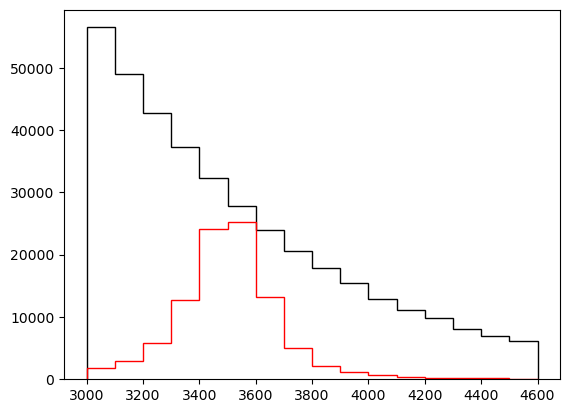

In [19]:
bkg = plt.hist(mjj_bg, bins=16, range=(3000, 4600), histtype="step", color="black")
bkg = bkg[0]
sig = plt.hist(mjj_sg, bins=16, range=(3000, 4600), histtype="step", color="red")
sig = sig[0]

In [20]:
x=np.linspace(3000, 4600, 17)
x=x[:-1]+(x[1]-x[0])/2

In [21]:
bkg_err = np.sqrt(bkg)
sig_err = np.sqrt(sig)

In [22]:
y_orig_err=np.sqrt(bkg_err**2)

In [23]:
s=13000
def fit(x, y, y_err, fff, s=13000):
	if fff == "5_param":
		f = (
				lambda x, p1, p2, p3, p4: p1
				* (1 - x / s) ** p2
				* (x / s) ** (p3 + p4 * np.log(x / s)+p5*np.log(x / s)**2)
			)
		rrr = scipy.optimize.curve_fit(
			f,
			x,
			y,
			sigma=y_err,
			p0=[2.067e7, 1.368, 0, 0, 0],
			bounds=(
				[0, -1000, -1000, -1000, -1000],
				[1000000000, 1000, 1000, 1000, 1000],
			),
			method=method,
		)
	elif fff == "4_param":
		f = (
				lambda x, p1, p2, p3, p4: p1
				* (1 - x / s) ** p2
				* (x / s) ** (p3 + p4 * np.log(x / s))
			)
		rrr = scipy.optimize.curve_fit(
			f,
			x,
			y,
			sigma=y_err,
			p0=[0.1523, 0.8516, -14.178, -3.57],
			bounds=(
				[0, -1000, -20, -20],
				[1000000000, 1000, 20, 20],
			),
			method=method,
		)
	elif fff == "3_param":
		f = (
				lambda x, p1, p2, p3: p1
				* (1 - x / s) ** p2
				* (x / s) ** p3
			)
		rrr = scipy.optimize.curve_fit(
			f,
			x,
			y,
			sigma=y_err,
			p0=[2.21e7, 1.376, -0.00968],
			bounds=(
				[0, -1000, -1000],
				[1000000000, 1000, 1000],
			),
			method=method,
		)
	return rrr, f



In [24]:
rrr, f = fit(x, bkg, y_orig_err, fff, s=13000)
fited_bkg = f(x, *rrr[0])
print(rrr)

(array([ 2.21070081e+06,  1.37635188e+01, -9.68215930e-03]), array([[1.04620680e+12, 5.70628705e+05, 2.22817977e+05],
       [5.70628705e+05, 3.11970333e-01, 1.21357685e-01],
       [2.22817977e+05, 1.21357685e-01, 4.74979330e-02]]))


1.4993824144132335
1.4501083475292778
1.4993824144132335


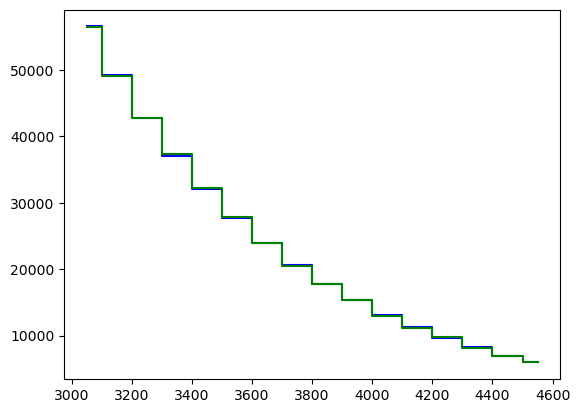

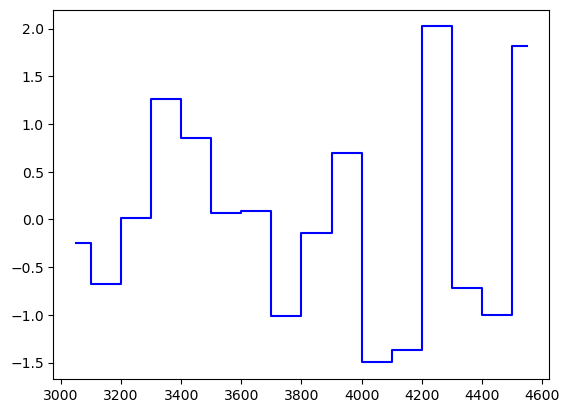

In [25]:
plt.step(x, fited_bkg, color="blue", where="mid")
plt.step(x, bkg, color="green", where="mid")
plt.figure()
plt.step(x, (bkg-fited_bkg)/y_orig_err, color="blue", where="mid")
print(MLSnormal_positiv(bkg, fited_bkg))
k = len(bkg)
print(np.sum((bkg-fited_bkg)**2/y_orig_err**2)/n_dof)
print(test_stat_f(bkg, fited_bkg))

In [26]:
test = np.max((bkg-fited_bkg)**2/y_orig_err**2)
print(test)

4.092269603491375


In [27]:
def random_sampling(y, y_err):
    return np.random.normal(y, y_err)

In [28]:
def get_tests(y_orig, n_trials, signal=None):
    y_orig_err = np.sqrt(y_orig)
    tests=[]
    for i in range(n_trials):
        if signal is not None:
            y = random_sampling(y_orig, y_orig_err) + signal
        else:
            y = random_sampling(y_orig, y_orig_err)
        rrr, f = fit(x, y, y_orig_err, fff, s=13000)
        fited = f(x, *rrr[0])
        test = test_stat_f(fited, y)
        tests.append(test)
    return tests

tests_bg = get_tests(fited_bkg, n_trials)

In [29]:
tests_sg_f = []
for sig_fraction in sig_fractions:
	sig_ = sig_fraction * sig
	tests_sg_f.append(get_tests(fited_bkg, 50, signal=sig_))

tests_sg_f = np.array(tests_sg_f)

1.650165483942161


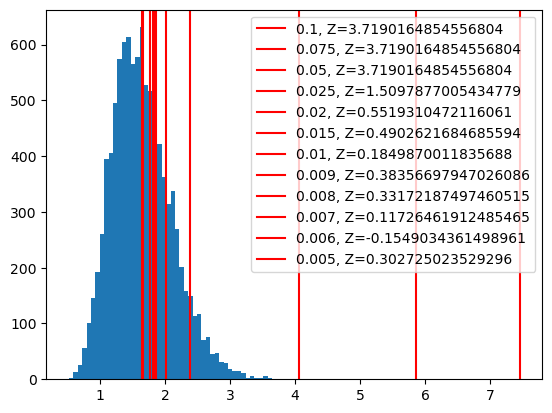

In [30]:
plt.hist(tests_bg, bins=50)
print(np.mean(tests_bg))
Zs = []
Zs_low = []
Zs_high = []
for i in range(len(sig_fractions)):
	ps = [1-np.mean(test>tests_bg) for test in tests_sg_f[i]]
	ps = np.array(ps)
	ps[ps==0]=1/n_trials
	Zs.append(p2Z(ps))
	plt.axvline(np.mean(tests_sg_f[i]), color="red", label=f"{sig_fractions[i]}, Z={np.median(Zs[i])}")
	#plt.axvline(np.median(tests_sg_f[i]), color="red", label=f"{sig_fractions[i]}, p={np.mean(np.median(tests_sg_f[i])>tests_bg)}")
plt.legend()

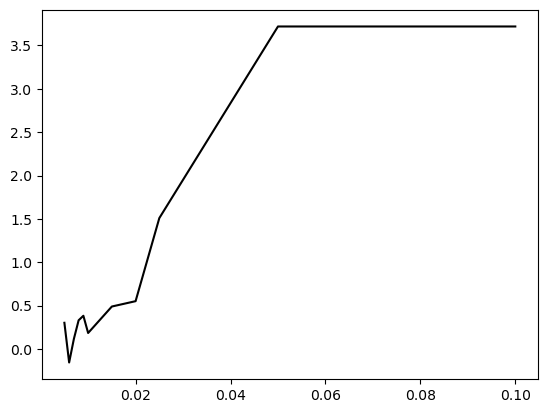

In [31]:
plt.plot(sig_fractions, [np.median(Zs_) for Zs_ in Zs], color="black")

In [32]:
import pickle
pickle.dump({"sig_fractions": np.array(sig_fractions), "Zs": np.array(Zs)}, open(save_directory+"Zs.pickle", "wb"))

In [33]:
np.array(sig_fractions)

array([0.1  , 0.075, 0.05 , 0.025, 0.02 , 0.015, 0.01 , 0.009, 0.008,
       0.007, 0.006, 0.005])

In [34]:
np.array(Zs)

array([[ 3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00],
       [ 3.71

In [35]:
np.array(sig_fractions) * len(mjj_sg)

array([10000.,  7500.,  5000.,  2500.,  2000.,  1500.,  1000.,   900.,
         800.,   700.,   600.,   500.])

Now make everything Idealised 

In [36]:
def get_tests(y_orig, n_trials, signal=None):
    y_orig_err = np.sqrt(y_orig)
    tests=[]
    for i in range(n_trials):
        if signal is not None:
            y = random_sampling(y_orig, y_orig_err) + signal
        else:
            y = random_sampling(y_orig, y_orig_err)
        test = test_stat_f(y_orig, y)
        tests.append(test)
    return tests

tests_bg = get_tests(bkg, n_trials)


In [37]:

tests_sg_f = []
for sig_fraction in sig_fractions:
	sig_ = sig_fraction * sig
	tests_sg_f.append(get_tests(bkg, 50, signal=sig_))

tests_sg_f = np.array(tests_sg_f)

1.7654147109424725


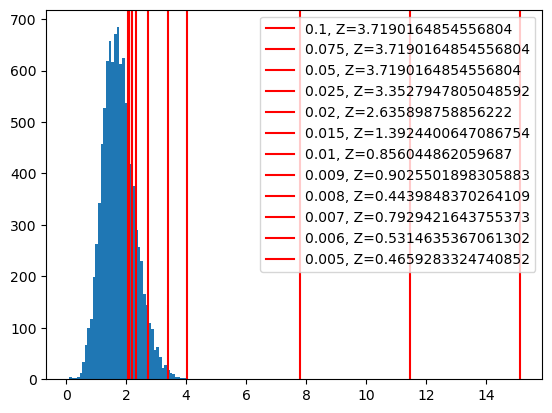

In [38]:
plt.hist(tests_bg, bins=50)
print(np.mean(tests_bg))
Zs = []
Zs_low = []
Zs_high = []
for i in range(len(sig_fractions)):
	ps = [1-np.mean(test>tests_bg) for test in tests_sg_f[i]]
	ps = np.array(ps)
	ps[ps==0]=1/n_trials
	Zs.append(p2Z(ps))
	plt.axvline(np.mean(tests_sg_f[i]), color="red", label=f"{sig_fractions[i]}, Z={np.median(Zs[i])}")
	#plt.axvline(np.median(tests_sg_f[i]), color="red", label=f"{sig_fractions[i]}, p={np.mean(np.median(tests_sg_f[i])>tests_bg)}")
plt.legend()

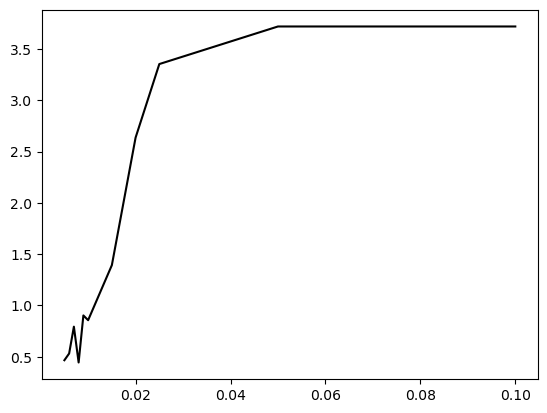

In [39]:
plt.plot(sig_fractions, [np.median(Zs_) for Zs_ in Zs], color="black")

In [40]:
import pickle
pickle.dump({"sig_fractions": np.array(sig_fractions), "Zs": np.array(Zs)}, open(save_directory+"Zs_ideal.pickle", "wb"))